In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings 
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("daily-website-visitors.csv",index_col="Date",parse_dates = True)
df = df.drop(df.columns[0], axis=1)
print('Sahpe of the data',df.shape)
df.head()

Sahpe of the data (2167, 6)


,Day,Day.Of.Week,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
Date,,,,,,
2014-09-14,Sunday,1,"2,146","1,582","1,430",152
2014-09-15,Monday,2,"3,621","2,528","2,297",231
2014-09-16,Tuesday,3,"3,698","2,630","2,352",278
2014-09-17,Wednesday,4,"3,667","2,614","2,327",287
2014-09-18,Thursday,5,"3,316","2,366","2,130",236


In [3]:
df.isnull().sum()

Day                  0
Day.Of.Week          0
Page.Loads           0
Unique.Visits        0
First.Time.Visits    0
Returning.Visits     0
dtype: int64

In [4]:
df['Page.Loads'] = df['Page.Loads'].str.replace(',', '').astype(int)
df['Unique.Visits'] = df['Unique.Visits'].str.replace(',', '').astype(int)
df['First.Time.Visits'] = df['First.Time.Visits'].str.replace(',', '').astype(int)
df['Returning.Visits'] = df['Returning.Visits'].str.replace(',', '').astype(int)

### Plotting the Trend for "Page Loads"

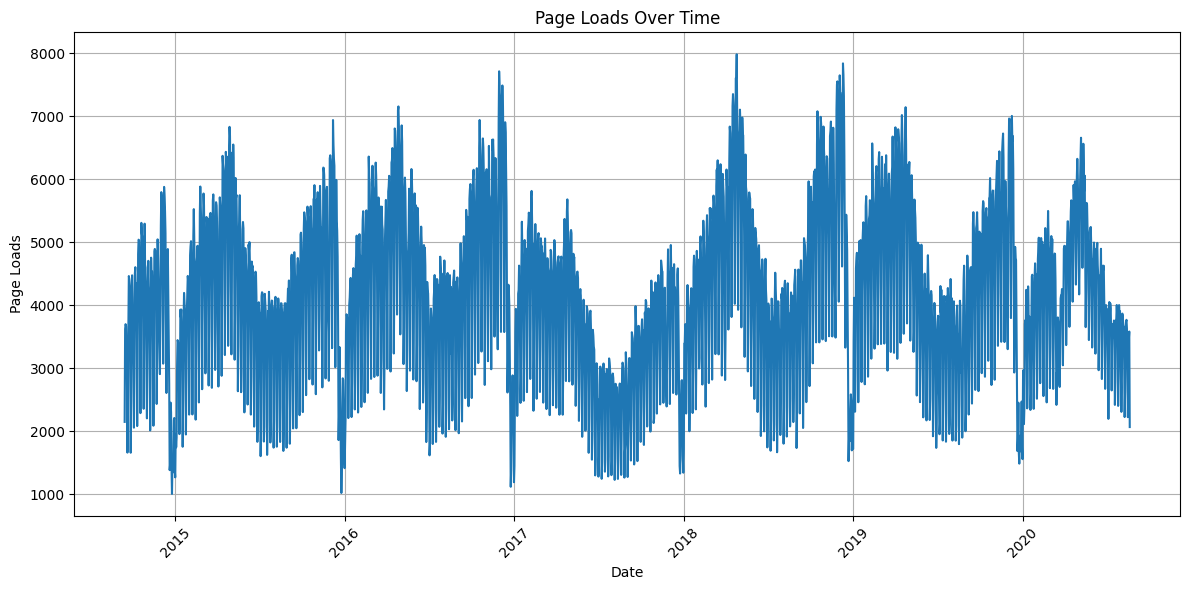

In [5]:
# Plotting the time trend
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Page.Loads'], linestyle='-')
plt.title('Page Loads Over Time')
plt.xlabel('Date')
plt.ylabel('Page Loads')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

### Check for Stationarity 

#### 1. Autocorrelation Function 

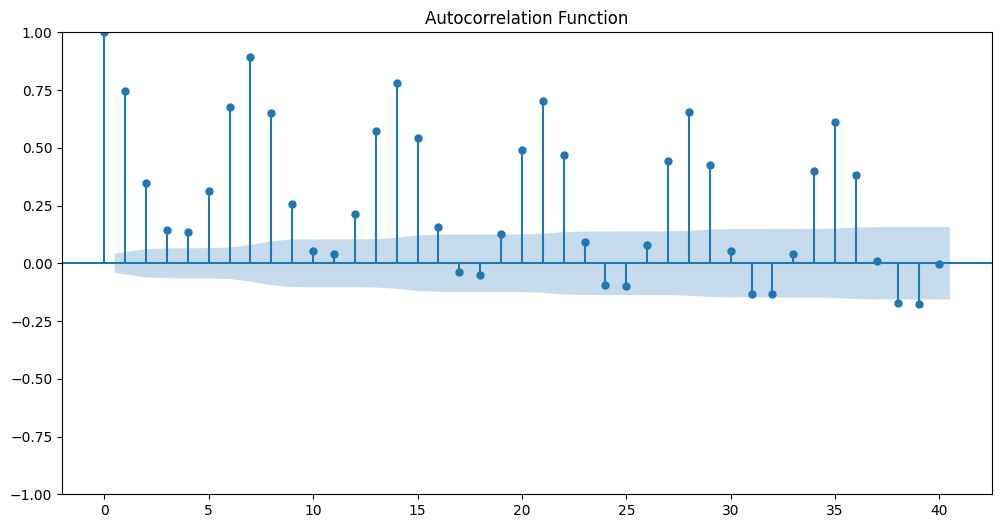

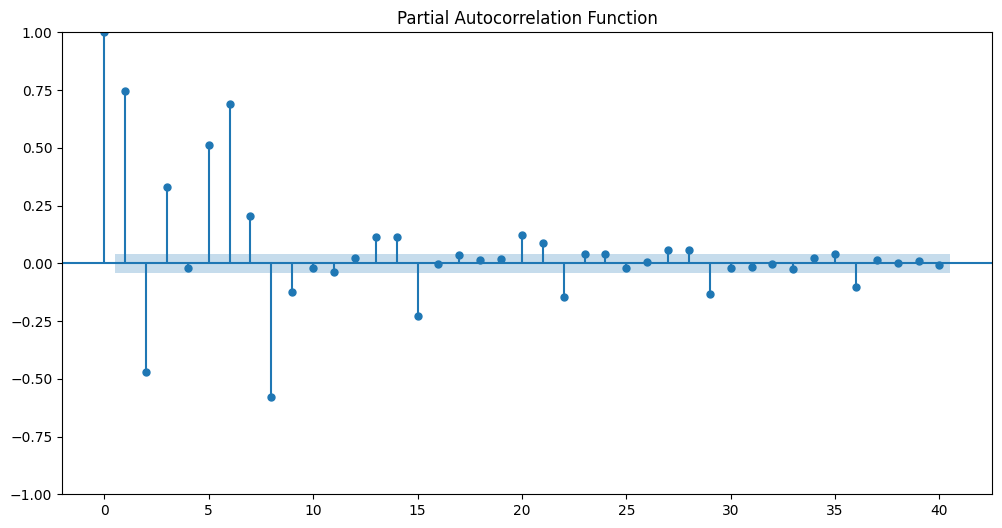

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotting the autocorrelation function (ACF) and partial autocorrelation function (PACF) for the entire dataset
plt.figure(figsize=(12, 6))
plot_acf(df['Page.Loads'], lags=40, ax=plt.gca())
plt.title('Autocorrelation Function')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df['Page.Loads'], lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Function')
plt.show()

**2. Seasonal Decomposition**

<Figure size 1200x800 with 0 Axes>

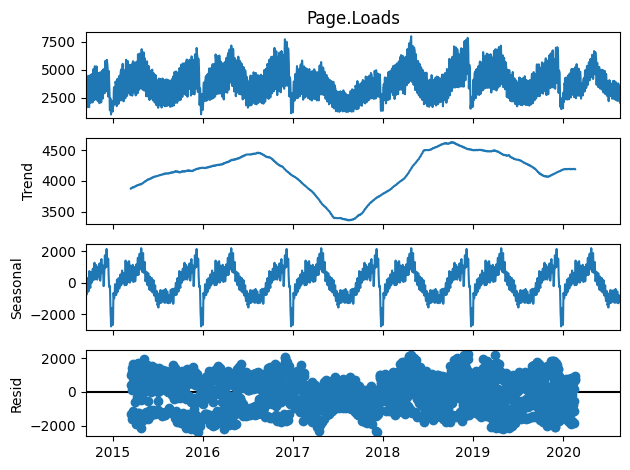

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(df['Page.Loads'], model='additive', period=365)

# Plot the decomposition
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.show()

#### 2. Augmented Dickey Fuller Test 

In [8]:
from statsmodels.tsa.stattools import adfuller 

def ad_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC',regression = 'ct')
    print ("1. ADF : ", dftest[0])
    print ("2. P-Value : ", dftest[1])
    print ("3. Num of Lags : ", dftest[2])
    print ("4. Num of Observations used : ", dftest[3])
    print ("5. Critical Values : ")
    for key, val in dftest[4].items():
        print("\t",key,": ",val)

ad_test(df['Page.Loads'])

1. ADF :  -4.255089219154289
2. P-Value :  0.0036908844764212585
3. Num of Lags :  26
4. Num of Observations used :  2140
5. Critical Values : 
	 1% :  -3.9630066417785947
	 5% :  -3.412543566512971
	 10% :  -3.128259083644411


Since the P-value is less that 0.05, it is ***STATIONARY*** and from the graphs we can conclude that there is ***SEASONALITY***.

### Order for ARIMA Model 

**Splitting into train and test sets**

In [9]:
train = df.iloc[:-30]
test = df.iloc[-30:]

# Extract only the Page.Loads column for ARIMA modeling
train_page_loads = train['Page.Loads']
test_page_loads = test['Page.Loads']

In [10]:
from pmdarima import auto_arima 

# Use auto_arima to find the optimal order with seasonality
stepwise_fit = auto_arima(train_page_loads, 
                          trace=True, 
                          suppress_warnings=True 
                          )

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=33412.166, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=35430.618, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=35248.928, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=34864.402, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=35428.619, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=34230.618, Time=0.56 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=33984.345, Time=0.43 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=33404.678, Time=0.91 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=34575.219, Time=0.37 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=31977.357, Time=1.02 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=33057.142, Time=0.62 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=31751.975, Time=1.41 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=32270.369, Time=0.56 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=31770.682, Time=1.37 sec
 ARIMA(4,1,3)(0,0,0

In [11]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2137
Model:               SARIMAX(5, 1, 2)   Log Likelihood              -15866.988
Date:                Sun, 28 Jul 2024   AIC                          31751.975
Time:                        18:17:10   BIC                          31802.975
Sample:                    09-14-2014   HQIC                         31770.639
                         - 07-20-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6891     11.995      0.057      0.954     -22.820      24.199
ar.L1          0.1939      0.028      6.891      0.000       0.139       0.249
ar.L2         -0.8971      0.021    -43.425      0.000      -0.938      -0.857
ar.L3         -0.1236      0.035     -3.538      0.000      -0.192      -0.055
ar.L4         -0.4691      0.021    -21.968      0.000      -0.511      -0.427
ar.L5         -0.5712      0.027    -21.018      0.000      -0.624      -0.518
ma.L1         -0.3732      0.029    -13.004      0.000      -0.429      -0.317
ma.L2          0.5026      0.024     20.677      0.000       0.455       0.550
sigma2      1.892e+05   5689.496     33.260      0.000    1.78e+05       2e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):               202.66
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                            -0.09
Prob(H) (two-sided):                  0.33   Kurtosis:                         4.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Fitting the Model 

In [12]:
from statsmodels.tsa.arima.model import ARIMA 

**Train the Model**

In [13]:
# Fit the ARIMA model using the optimal order found by auto_arima
model = ARIMA(train_page_loads, 
              order=stepwise_fit.order, 
              seasonal_order=stepwise_fit.seasonal_order)
model_fit = model.fit()
model_fit.summary()

/Users/raghavirajumohan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/raghavirajumohan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/raghavirajumohan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/raghavirajumohan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Page.Loads   No. Observations:                 2137
Model:                 ARIMA(5, 1, 2)   Log Likelihood              -15875.795
Date:                Sun, 28 Jul 2024   AIC                          31767.590
Time:                        18:17:11   BIC                          31812.924
Sample:                    09-14-2014   HQIC                         31784.180
                         - 07-20-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1124      0.029      3.887      0.000       0.056       0.169
ar.L2         -0.8413      0.021    -39.460      0.000      -0.883      -0.799
ar.L3         -0.2232      0.036     -6.174      0.000      -0.294      -0.152
ar.L4         -0.4061      0.022    -18.054      0.000      -0.450      -0.362
ar.L5         -0.6417      0.028    -22.934      0.000      -0.696      -0.587
ma.L1         -0.2767      0.030     -9.199      0.000      -0.336      -0.218
ma.L2          0.4937      0.027     18.338      0.000       0.441       0.546
sigma2       2.06e+05   6701.368     30.735      0.000    1.93e+05    2.19e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.13   Jarque-Bera (JB):               182.82
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                            -0.02
Prob(H) (two-sided):                  0.36   Kurtosis:                         4.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Predictions on Test Set**

In [14]:
# Forecast the values for the test set
pred = model_fit.forecast(steps=len(test_page_loads))

# Convert the predictions to a pandas Series
pred = pd.Series(pred, index=test.index)

# Print the predictions
print(pred)

Date
2020-07-21    3612.584375
2020-07-22    3494.452707
2020-07-23    3789.612647
2020-07-24    3322.498443
2020-07-25    2490.030746
2020-07-26    2859.037628
2020-07-27    3661.041214
2020-07-28    3626.877986
2020-07-29    3503.758058
2020-07-30    3723.948355
2020-07-31    3297.444262
2020-08-01    2591.012425
2020-08-02    2893.172590
2020-08-03    3606.213567
2020-08-04    3621.766163
2020-08-05    3516.757119
2020-08-06    3663.291228
2020-08-07    3281.193308
2020-08-08    2674.568539
2020-08-09    2927.776865
2020-08-10    3559.729699
2020-08-11    3614.299274
2020-08-12    3523.795110
2020-08-13    3613.073378
2020-08-14    3267.966870
2020-08-15    2746.615640
2020-08-16    2960.144714
2020-08-17    3521.587061
2020-08-18    3604.293763
2020-08-19    3526.762772
Name: predicted_mean, dtype: float64


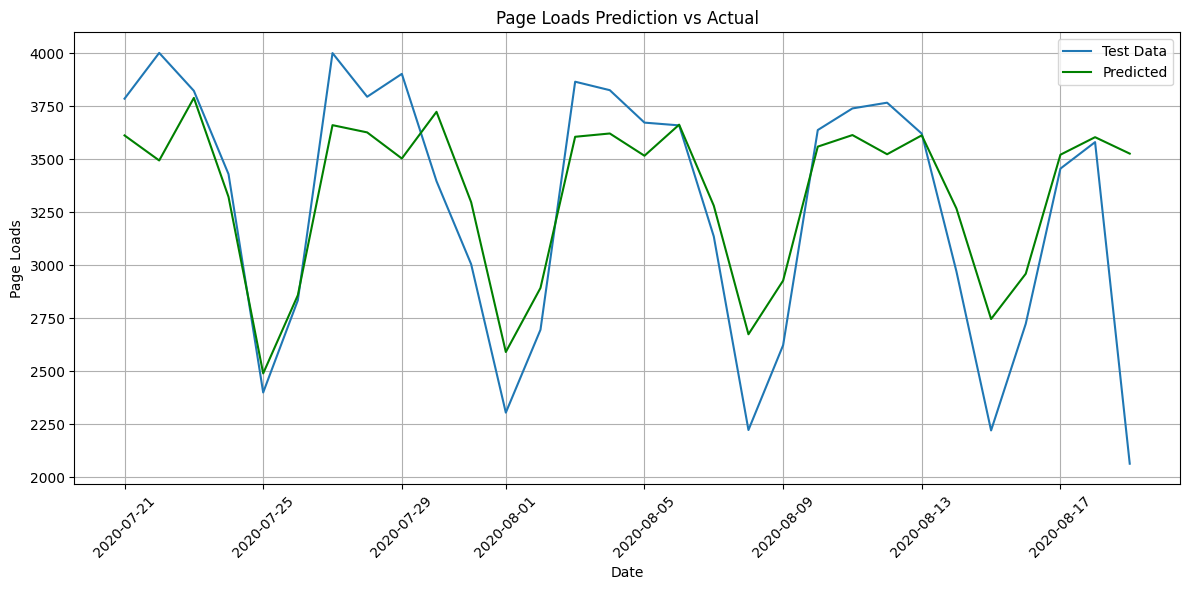

In [15]:

# Plotting the forecast against actual values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Page.Loads'], label='Test Data')
plt.plot(pred.index, pred, label='Predicted', color='green')
plt.title('Page Loads Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Page Loads')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Calculate RMSE
rmse = sqrt(mean_squared_error(test_page_loads, pred))
print("Root Mean Squared Error:", rmse)

print("Mean Value:", test_page_loads.mean())


Root Mean Squared Error: 366.1853950121964
Mean Value: 3272.266666666667


## Future Predictions 

### Retrain Model on entire Data Set 

In [17]:
model2 = ARIMA(df['Page.Loads'], 
              order=stepwise_fit.order, 
              seasonal_order=stepwise_fit.seasonal_order)
model2_fit = model.fit()
model2_fit.summary()

/Users/raghavirajumohan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/raghavirajumohan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/raghavirajumohan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/raghavirajumohan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Page.Loads   No. Observations:                 2137
Model:                 ARIMA(5, 1, 2)   Log Likelihood              -15875.795
Date:                Sun, 28 Jul 2024   AIC                          31767.590
Time:                        18:17:22   BIC                          31812.924
Sample:                    09-14-2014   HQIC                         31784.180
                         - 07-20-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1124      0.029      3.887      0.000       0.056       0.169
ar.L2         -0.8413      0.021    -39.460      0.000      -0.883      -0.799
ar.L3         -0.2232      0.036     -6.174      0.000      -0.294      -0.152
ar.L4         -0.4061      0.022    -18.054      0.000      -0.450      -0.362
ar.L5         -0.6417      0.028    -22.934      0.000      -0.696      -0.587
ma.L1         -0.2767      0.030     -9.199      0.000      -0.336      -0.218
ma.L2          0.4937      0.027     18.338      0.000       0.441       0.546
sigma2       2.06e+05   6701.368     30.735      0.000    1.93e+05    2.19e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.13   Jarque-Bera (JB):               182.82
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                            -0.02
Prob(H) (two-sided):                  0.36   Kurtosis:                         4.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Prediction for the next Month

In [18]:
df.tail()

,Day,Day.Of.Week,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
Date,,,,,,
2020-08-15,Saturday,7,2221,1696,1373,323
2020-08-16,Sunday,1,2724,2037,1686,351
2020-08-17,Monday,2,3456,2638,2181,457
2020-08-18,Tuesday,3,3581,2683,2184,499
2020-08-19,Wednesday,4,2064,1564,1297,267


In [21]:
### Prediction for the next month
index_future_dates = pd.date_range(start='2020-08-19', end='2020-09-19')

# Predict future values
pred = model2_fit.predict(start=len(df), end=len(df) + len(index_future_dates) - 1, typ='levels').rename('ARIMA Predictions')

# Convert the future predictions to a pandas Series
pred.index = index_future_dates

print(pred)

2020-08-19    3570.964733
2020-08-20    3257.690569
2020-08-21    2808.759705
2020-08-22    2990.389303
2020-08-23    3490.196954
2020-08-24    3592.642672
2020-08-25    3526.467299
2020-08-26    3535.582931
2020-08-27    3249.903156
2020-08-28    2862.588374
2020-08-29    3018.484871
2020-08-30    3464.367240
2020-08-31    3579.953591
2020-09-01    3523.636874
2020-09-02    3505.756534
2020-09-03    3244.225384
2020-09-04    2909.400163
2020-09-05    3044.472341
2020-09-06    3443.103254
2020-09-07    3566.696102
2020-09-08    3518.867956
2020-09-09    3480.529755
2020-09-10    3240.320881
2020-09-11    2950.275724
2020-09-12    3068.425981
2020-09-13    3425.584727
2020-09-14    3553.224188
2020-09-15    3512.650809
2020-09-16    3459.119444
2020-09-17    3237.895610
2020-09-18    2986.113985
2020-09-19    3090.442783
Freq: D, Name: ARIMA Predictions, dtype: float64


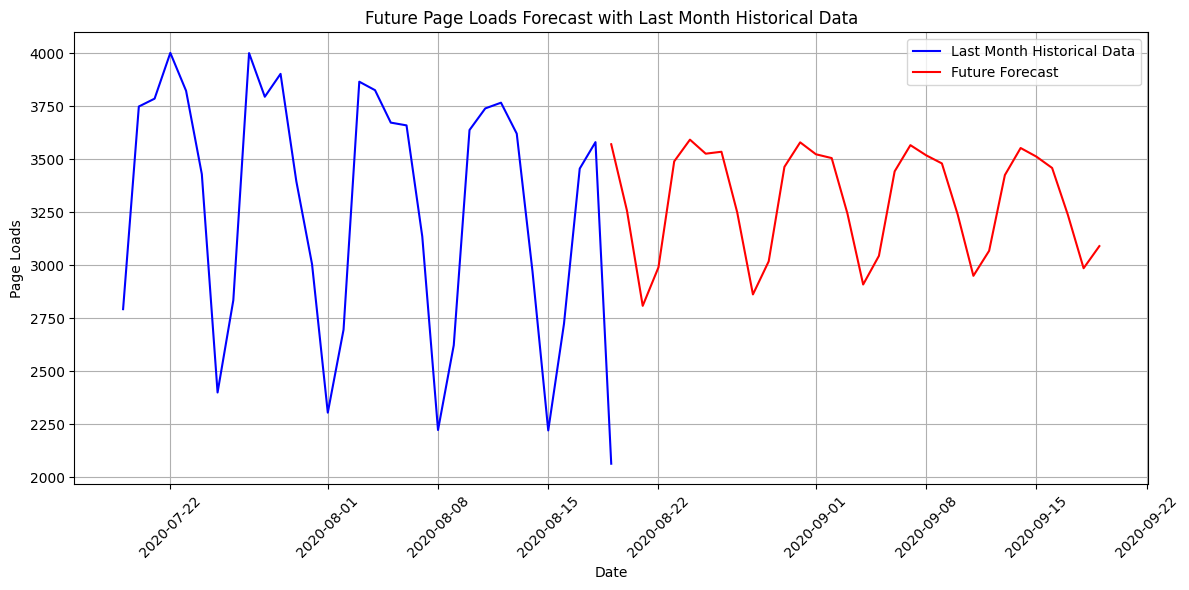

In [20]:
# Extract the last month of historical data
last_month_data = df['Page.Loads'].loc['2020-07-19':'2020-08-20']

# Plotting the future forecast along with the last month of historical data
plt.figure(figsize=(12, 6))
plt.plot(last_month_data.index, last_month_data, label='Last Month Historical Data', color='blue')
plt.plot(pred.index, pred, label='Future Forecast', color='red')
plt.title('Future Page Loads Forecast with Last Month Historical Data')
plt.xlabel('Date')
plt.ylabel('Page Loads')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()